In [43]:
from matplotlib import pyplot as plt
from utils.flowlib import read_flow, flow_to_image
import cv2
import numpy as np
import skimage
from models.VCN import VCN
import torch
import torch.nn as nn
from torch.autograd import Variable

In [44]:
def point_vec(img,flow):
    meshgrid = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    dispimg = cv2.resize(img, None,fx=4,fy=4)
    colorflow = flow_to_image(flow).astype(int)
    for i in range(img.shape[1]): # x 
        for j in range(img.shape[0]): # y
            if flow[j,i,2] != 1: continue
            if j%10!=0 or i%10!=0: continue
            xend = int((meshgrid[0][j,i]+flow[j,i,0])*4)
            yend = int((meshgrid[1][j,i]+flow[j,i,1])*4)
            leng = np.linalg.norm(flow[j,i,:2])
            if leng<1:continue
            dispimg = cv2.arrowedLine(dispimg, (meshgrid[0][j,i]*4,meshgrid[1][j,i]*4),\
                                      (xend,yend),
                                      (int(colorflow[j,i,2]),int(colorflow[j,i,1]),int(colorflow[j,i,0])),5,tipLength=8/leng,line_type=cv2.LINE_AA)
    return dispimg        

In [45]:
def inference(imgL_o, imgR_o, maxdisp, fac, modelpath):
    # resize to 64X
    maxh = imgL_o.shape[0]
    maxw = imgL_o.shape[1]
    max_h = int(maxh // 64 * 64)
    max_w = int(maxw // 64 * 64)
    if max_h < maxh: max_h += 64
    if max_w < maxw: max_w += 64

    input_size = imgL_o.shape
    imgL = cv2.resize(imgL_o,(max_w, max_h))
    imgR = cv2.resize(imgR_o,(max_w, max_h))

    # load model
    model = VCN([1, max_w, max_h], md=[int(4*(maxdisp/256)),4,4,4,4], fac=fac)

    model = nn.DataParallel(model, device_ids=[0])
    model.cuda()

    # load weights
    pretrained_dict = torch.load(modelpath)
    mean_L=pretrained_dict['mean_L']
    mean_R=pretrained_dict['mean_R']
    model.load_state_dict(pretrained_dict['state_dict'],strict=False)

    print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

    # for gray input images
    if len(imgL_o.shape) == 2:
        imgL_o = np.tile(imgL_o[:,:,np.newaxis],(1,1,3))
        imgR_o = np.tile(imgR_o[:,:,np.newaxis],(1,1,3))


    # flip channel, subtract mean
    imgL = imgL[:,:,::-1].copy() / 255. - np.asarray(mean_L).mean(0)[np.newaxis,np.newaxis,:]
    imgR = imgR[:,:,::-1].copy() / 255. - np.asarray(mean_R).mean(0)[np.newaxis,np.newaxis,:]
    imgL = np.transpose(imgL, [2,0,1])[np.newaxis]
    imgR = np.transpose(imgR, [2,0,1])[np.newaxis]

    # forward
    imgL = Variable(torch.FloatTensor(imgL).cuda())
    imgR = Variable(torch.FloatTensor(imgR).cuda())
    with torch.no_grad():
        imgLR = torch.cat([imgL,imgR],0)
        model.eval()
        rts = model(imgLR)
        pred_disp, entropy = rts

    # upsampling
    pred_disp = torch.squeeze(pred_disp).data.cpu().numpy()
    pred_disp = cv2.resize(np.transpose(pred_disp,(1,2,0)), (input_size[1], input_size[0]))
    pred_disp[:,:,0] *= input_size[1] / max_w
    pred_disp[:,:,1] *= input_size[0] / max_h
    flow = np.ones([pred_disp.shape[0],pred_disp.shape[1],3])
    flow[:,:,:2] = pred_disp
    entropy = torch.squeeze(entropy).data.cpu().numpy()
    entropy = cv2.resize(entropy, (input_size[1], input_size[0]))
    return flow, entropy

In [60]:
### in the wild data
imgL_o = skimage.io.imread('./dataset/IIW/hawk_000299.png') # load two input images
imgR_o = skimage.io.imread('./dataset/IIW/hawk_000300.png')

maxdisp=256 # maximum disparity to search over (along each direction)
fac=1       # shape of the search window -> 1 results in a square window

modelpath = './weights/sintel-ft-trainval/finetune_67999.tar'

# ### KITTI
# imgL_o = skimage.io.imread('./dataset/kitti_scene/testing/image_2/000042_10.png') # load two input images
# imgR_o = skimage.io.imread('./dataset/kitti_scene/testing/image_2/000042_11.png')

# maxdisp=512 # maximum disparity to search over (along each direction)
# fac=2       # shape of the search window -> 2 results in a horizontal rectangle

# modelpath = './weights/kitti-ft-trainval/finetune_149999.tar'

In [61]:
flow,entropy = inference(imgL_o, imgR_o, maxdisp, fac, modelpath)

Number of model parameters: 6227224


In [62]:
##  visualize pre-generated results
# imgL_o = cv2.imread('./dataset/kitti_scene/testing/image_2/000042_10.png')
# flow = read_flow('weights/kitti-ft-trainval/2015test/000042_10.png')

(-0.5, 1919.5, 1079.5, -0.5)

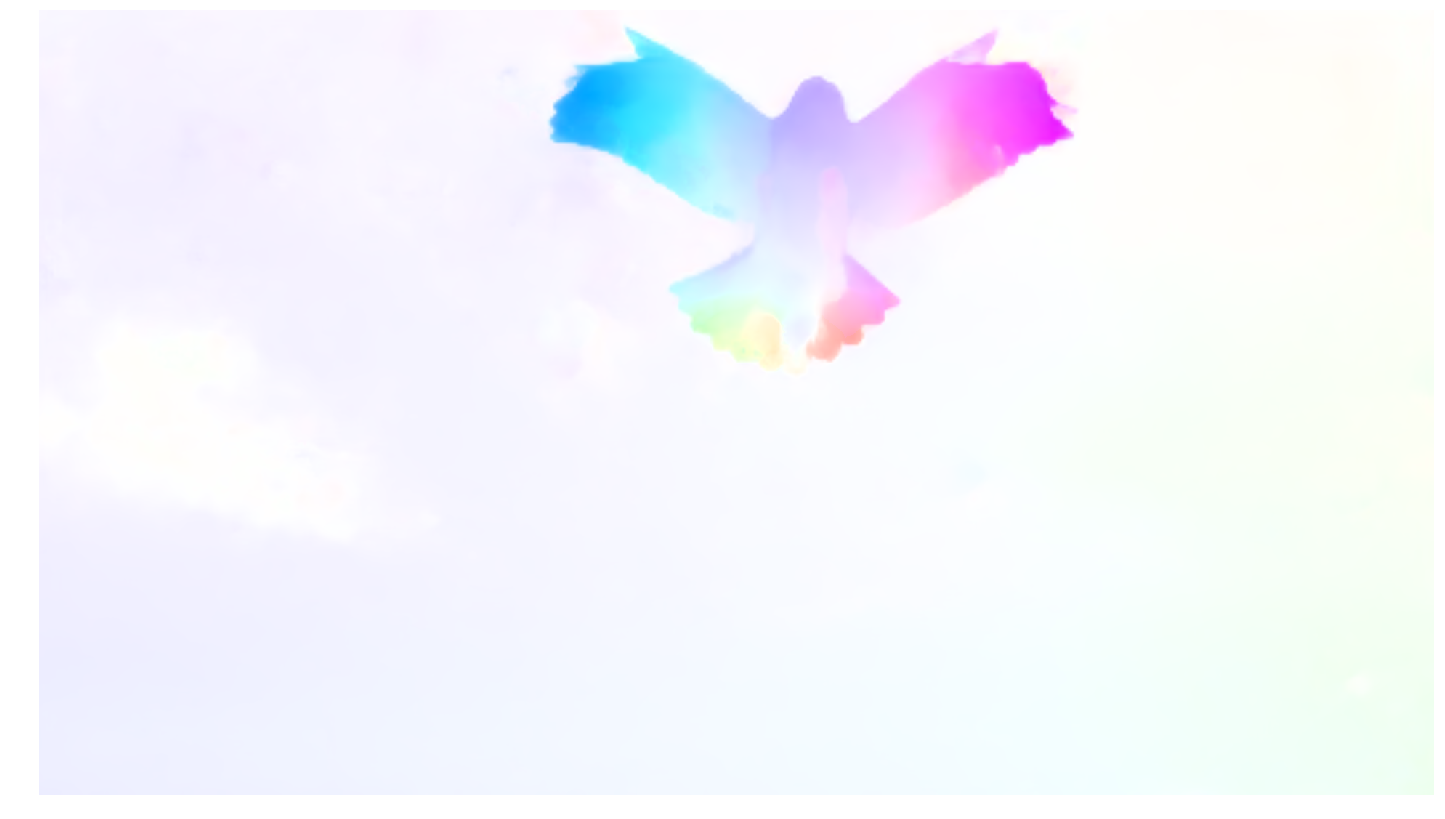

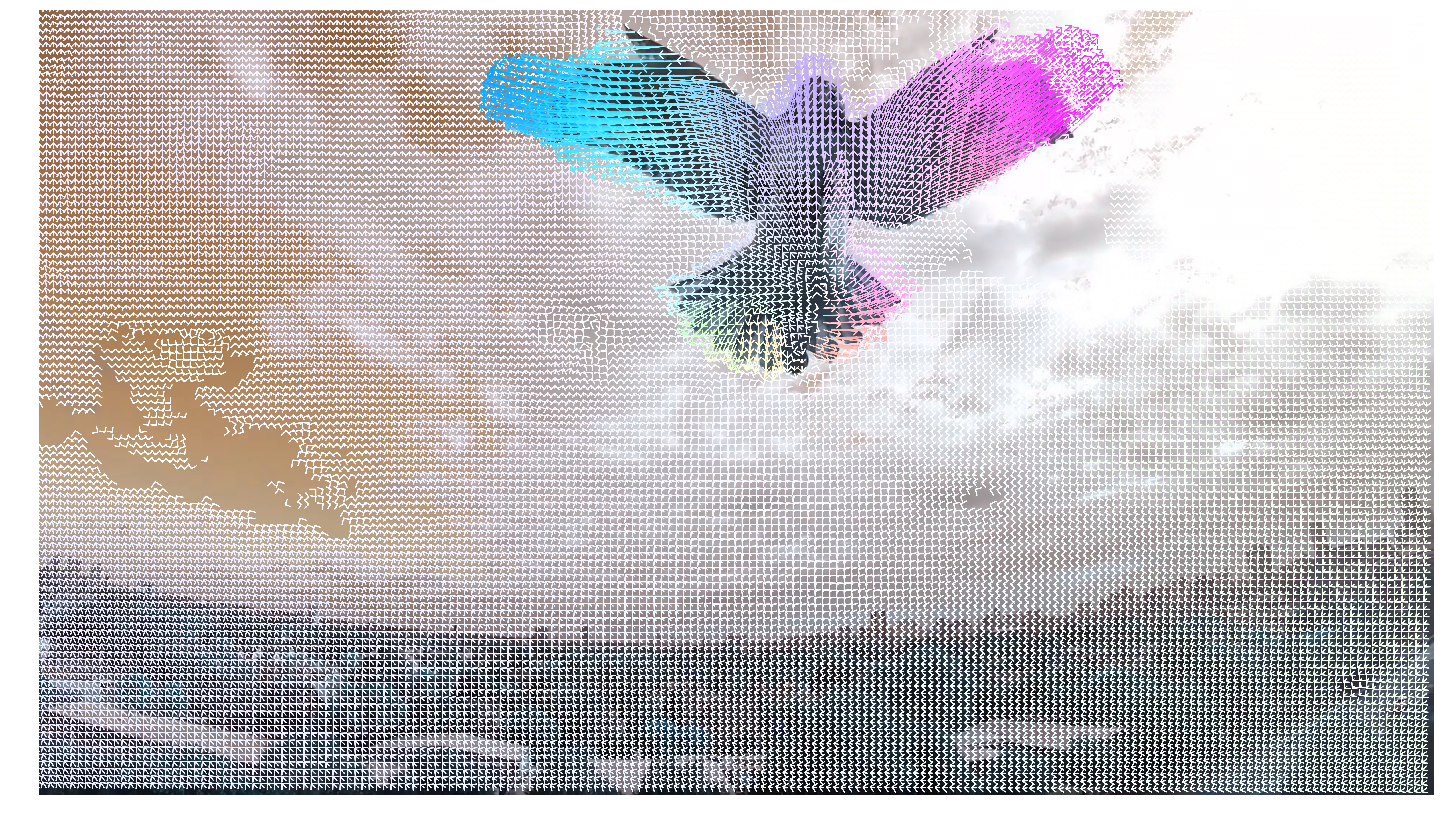

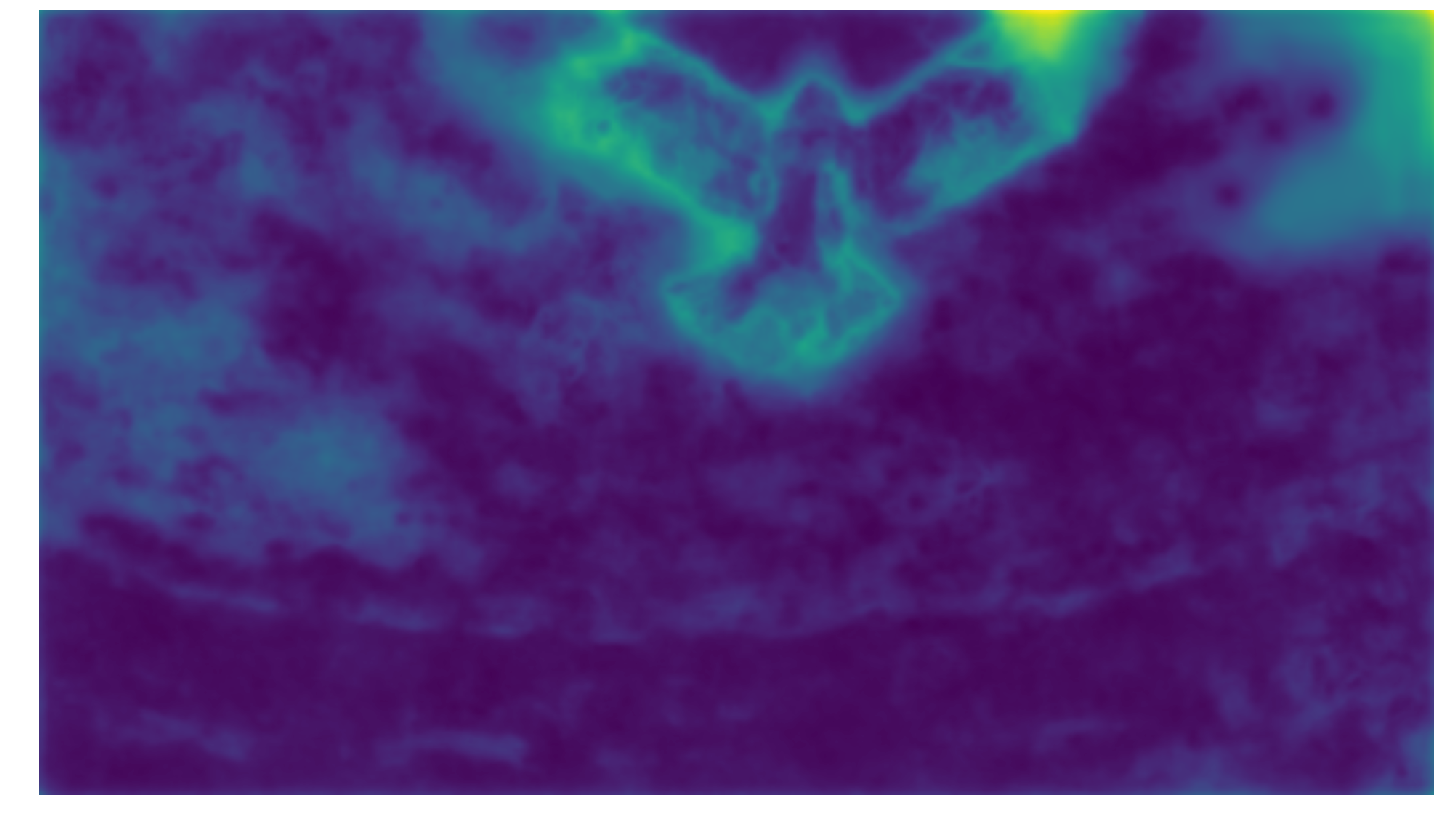

In [65]:
plt.figure(figsize=(25,25))
plt.imshow(flow_to_image(flow))
plt.axis('off')
plt.figure(figsize=(25,25))
dispimg = point_vec(imgL_o,flow)
plt.imshow(dispimg[:,:,::-1])
plt.axis('off')
plt.figure(figsize=(25,25))
plt.imshow(entropy)
plt.axis('off')